# Lojistik Regresyon
- Amaç sınıflandırma problemi için bağımlı ve bağımsız değişkenler arasındaki ilişkiyi doğrusal olarak modellemektir.
- Gerçek değerler ile tahmin edilen değerler arasındaki farklara ilişkin log loss değerini minimum yapacak ağırlıkları bularak.
<br>
<img src="https://miro.medium.com/max/1400/1*WI_I5ecz7PQjeE4FebLfDQ@2x.png">

## Confisuion Matrix
- Confusion Matrix, veri setinin doğruluk oranlarını gösteren bir matrisdir.
- <img src = "https://miro.medium.com/max/1286/1*TaunhmpZ3DVPPrGmlQDRog.png">
- accuracy = (TP + TN) / (TP + TN + FP + FN) Accuracy değeri, doğru sınıfların oranıdır.
- precision = TP / (TP + FP) Precision değeri pozitif sınıfın tahminlerinin başarı oranıdır.
- recall = TP / (TP + FN) Recall değeri, pozitif sınıfın doğru tahmin edilme oranıdır.


# ROC Eğrisi
<img src="https://bilisim.io/wp-content/uploads/2020/12/roc-curve-original.jpg">

## Area Under the Curve (AUC)
- ROC Eğrisinin tek bir sayısal değerle ifade edilişidir.
- ROC eğrisi altında kalan alan
- AUC değeri, tüm olası sınıflandırma eşikleri için toplu bir performans ölçüsüdür.

# Diabetes Prediction with Logistic Regression

## İş Problemi:

- Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadıklarını tahmin edebilecek bir makine öğrenmesi modeli geliştirebilir misiniz?
- Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır. ABD'deki Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan
- Pima Indian kadınları üzerinde yapılan diyabet araştırması için kullanılan verilerdir. 768 gözlem ve 8 sayısal bağımsız değişkenden oluşmaktadır. Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.

## Değişkenler
- Pregnancies: Hamilelik sayısı
- Glucose: Glikoz.
- BloodPressure: Kan basıncı.
- SkinThickness: Cilt Kalınlığı
- Insulin: İnsülin.
- BMI: Beden kitle indeksi.
- DiabetesPedigreeFunction: Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir fonksiyon.
- Age: Yaş (yıl)
- Outcome: Kişinin diyabet olup olmadığı bilgisi. Hastalığa sahip (1) ya da değil (0)


1. Exploratory Data Analysis
2. Data Preprocessing
3. Model & Prediction
4. Model Evaluation
5. Model Validation: Holdout
6. Model Validation: 10-Fold Cross Validation
7. Prediction for A New Observation


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate

def outlierThresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantileRange = quartile3 - quartile1
    upLimit = quartile3 + 1.5 * interquantileRange
    lowLimit = quartile1 - 1.5 * interquantileRange
    return lowLimit, upLimit

def checkOutlier(dataframe, col_name):
    lowLimit, upLimit = outlierThresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > upLimit) | (dataframe[col_name] < lowLimit)].any(axis=None):
        return True
    else:
        return False

def replaceWithThresholds(dataframe, variable):
    lowLimit, upLimit = outlierThresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < lowLimit), variable] = lowLimit
    dataframe.loc[(dataframe[variable] > upLimit), variable] = upLimit


pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)


**Keşifçi Veri Analizi(EDA)**

In [3]:
df = pd.read_csv("datasets/diabetes.csv")

**Target'ın Analizi**

In [8]:
df["Outcome"].value_counts()


0    500
1    268
Name: Outcome, dtype: int64

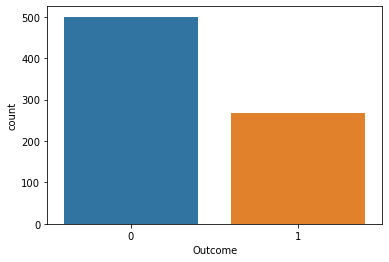

0   65.104
1   34.896
Name: Outcome, dtype: float64

In [9]:
sns.countplot(x="Outcome", data=df)
plt.show()

100 * df["Outcome"].value_counts() / len(df)

**Feature Analizi**

In [10]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


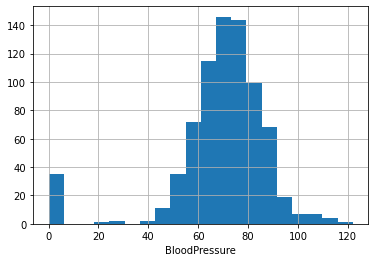

In [12]:
df["BloodPressure"].hist(bins=20)
plt.xlabel("BloodPressure")
plt.show()

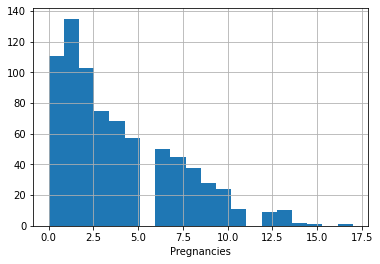

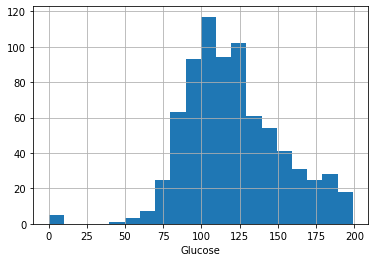

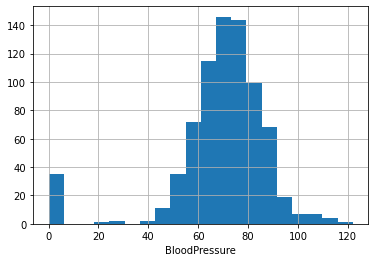

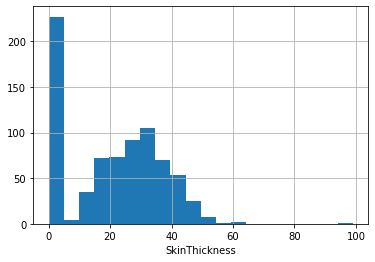

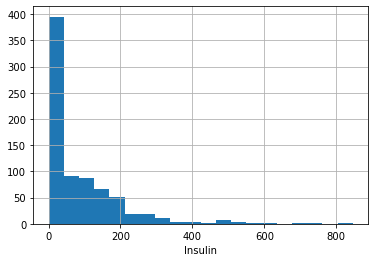

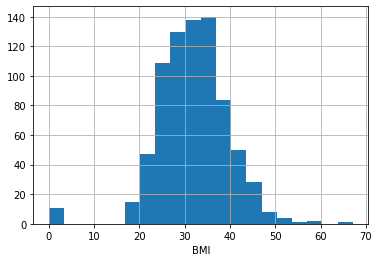

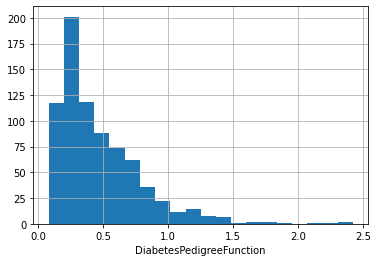

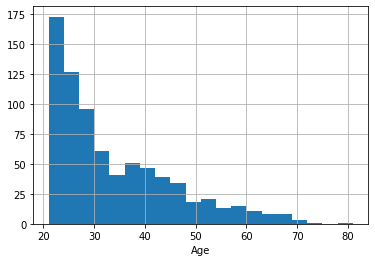

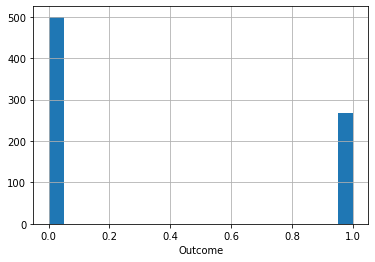

In [13]:
def plotNumericalCol(dataframe, numericalCol):
    dataframe[numericalCol].hist(bins=20)
    plt.xlabel(numericalCol)
    plt.show(block=True)


for col in df.columns:
    plotNumericalCol(df, col)

cols = [col for col in df.columns if "Outcome" not in col]

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


**Target vs Features**

In [15]:
df.groupby("Outcome").agg({"Pregnancies": "mean"})

,Pregnancies
Outcome,
0,3.298
1,4.866


In [16]:
def targetSummaryWithNum(dataframe, target, numericalCol):
    print(dataframe.groupby(target).agg({numericalCol: "mean"}), end="\n\n\n")

for col in cols:
    targetSummaryWithNum(df, "Outcome", col)



         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




**Veri Önişleme**

In [17]:
df.shape

(768, 9)

In [18]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [19]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [21]:
for col in cols:
    print(col, checkOutlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


In [22]:
replaceWithThresholds(df, "Insulin")

In [24]:

for col in cols:
    df[col] = RobustScaler().fit_transform(df[[col]])

In [25]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.600,0.752,0.000,0.375,-0.240,0.172,0.665,1.235,1
1,-0.400,-0.776,-0.333,0.188,-0.240,-0.581,-0.056,0.118,0
2,1.000,1.600,-0.444,-0.719,-0.240,-0.935,0.783,0.176,1
3,-0.400,-0.679,-0.333,0.000,0.499,-0.419,-0.537,-0.471,0
4,-0.600,0.485,-1.778,0.375,1.081,1.194,5.008,0.235,1


**Model & Prediction**

In [26]:
y = df["Outcome"]

X = df.drop(["Outcome"], axis=1)

logModel = LogisticRegression().fit(X, y)

logModel.intercept_

array([-1.23439588])

In [27]:
logModel.coef_

array([[ 0.59906785,  1.41770936, -0.23152362,  0.01973855, -0.14571255,
         0.81741997,  0.35522795,  0.25655154]])

In [29]:
yPred = logModel.predict(X)
yPred[0:10]


array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0], dtype=int64)

In [30]:
y[0:10]

0    1
1    0
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    1
Name: Outcome, dtype: int64

**Model Evulation**

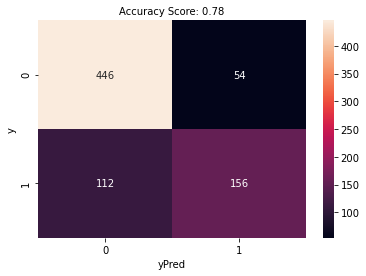

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



In [31]:
def plotConfusionMatrix(y, yPred):
    acc = round(accuracy_score(y, yPred), 2)
    cm = confusion_matrix(y, yPred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('yPred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plotConfusionMatrix(y, yPred)

print(classification_report(y, yPred))

In [32]:
# Accuracy: 0.78
# Precision: 0.74
# Recall: 0.58
# F1-score: 0.65

# ROC AUC
yProb = logModel.predict_proba(X)[:, 1]
roc_auc_score(y, yProb)
# 0.83939


0.8393955223880598

**Model Validation: Holdout**

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20, random_state=17)

logModel = LogisticRegression().fit(X_train, y_train)

yPred = logModel.predict(X_test)
yProb = logModel.predict_proba(X_test)[:, 1]

print(classification_report(y_test, yPred))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        97
           1       0.79      0.53      0.63        57

    accuracy                           0.77       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.77      0.76       154



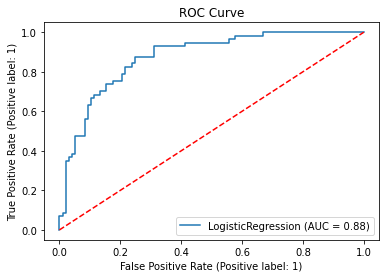

In [35]:
# Accuracy: 0.78
# Precision: 0.74
# Recall: 0.58
# F1-score: 0.65

# Accuracy: 0.77
# Precision: 0.79
# Recall: 0.53
# F1-score: 0.63

plot_roc_curve(logModel, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [37]:
# AUC
roc_auc_score(y_test, yProb)

0.8755652016639537

**Model Validation: 10-Fold Cross Validation**

In [38]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

logModel = LogisticRegression().fit(X, y)

cvResults = cross_validate(logModel,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])



# Accuracy: 0.78
# Precision: 0.74
# Recall: 0.58
# F1-score: 0.65

# Accuracy: 0.77
# Precision: 0.79
# Recall: 0.53
# F1-score: 0.63


In [39]:
cvResults['test_accuracy'].mean()
# Accuracy: 0.7721

0.7721925133689839

In [40]:
cvResults['test_precision'].mean()
# Precision: 0.7192

0.7192472060223519

In [41]:
cvResults['test_recall'].mean()
# Recall: 0.5747

0.5747030048916841

In [42]:
cvResults['test_f1'].mean()
# F1-score: 0.6371

0.6371421090986309

In [43]:
cvResults['test_roc_auc'].mean()
# AUC: 0.8327

0.8327295597484277

In [44]:
random_user = X.sample(1, random_state=45)
logModel.predict(random_user)

array([1], dtype=int64)